# Links
+ [Medium Article: **Quantamental Approach to Stock Trading Using the Fourier Analysis**](https://medium.com/intuition/quantamental-approach-to-stock-trading-using-the-fourier-analysis-58f64792290)
+ [Medium Article: **Digital Signal Processing for Predicting Stock Prices**](https://medium.com/@sadatnazrul/digital-signal-processing-for-predicting-stock-prices-4be247a09514)
+ [YouTube Video: **All Types of Fourier Transforms in PYTHON**](https://www.youtube.com/watch?v=GKsCWivmlHg)
+ [YouTube Video: **The intuition behind Fourier and Laplace transforms I was never taught in school**](https://www.youtube.com/watch?v=3gjJDuCAEQQ)

In [1]:
# ------------------------------------------------------------------------------
# LIBRARIES
# ------------------------------------------------------------------------------

# Base libraries
import warnings

# Data Libraries
import numpy as np
import pandas as pd
import yfinance as yf

# Math libraries
import scipy

# Plotting libraries
import plotly.express as px
from plotly import graph_objects as go
import plotly.io as pio
from IPython.display import display, Markdown

# Personal libraries/modules
%load_ext autoreload
%autoreload 2
import data_processing as dp
import plotting_tools as pt

# Libraries configurations
custom_template = pt.generate_plotly_transparent_template(
    color_sequence=pt.CYBERPUNK_COLOR_SEQUENCE,
    title_font_color=pt.FONT_COLOR,
    axis_font_color=pt.FONT_COLOR,
    axis_tick_color=pt.FONT_COLOR,
    axis_grid_color=pt.AXIS_COLOR,
    legend_font_color=pt.FONT_COLOR,
    plot_width=pt.WIDTH,
    plot_height=pt.HEIGHT
)

pio.templates.default = custom_template
pd.options.plotting.backend = 'plotly'
pd.options.mode.chained_assignment = None

# Filter out future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fourier Transforms
The **intuition** behind the Fourier Transforms is that it allows us to break down a collection of signals into their constituent components. This is useful in finance as we have the hypothesis that markets behave in cyclical form, and thus, with judicious application of the Fourier Transform, we could, in theory, uncover hidden pattern in market cycles.

The FT of a function $f(t)$ is defined as

$$F(\omega) = \int_{-\infty}^{\infty} f(t)e^{-i\omega t} \, dt\tag{Fourier Transform}$$

We have that the Euler's formula can be replaced inside the FT formula

$$e^{-i\omega t} = \cos(\omega t) - i \sin(\omega t)$$

$$F(\omega) = \int_{-\infty}^{\infty} f(t)(\cos \omega t - i \sin \omega t) \, dt$$

After distributing the $f(t)$ and separating the integrals we have:

$$F(\omega) = \int_{-\infty}^{\infty} f(t) \cos (\omega t) \, dt - i \int_{-\infty}^{\infty} f(t) \sin (\omega t) \, dt$$

This means that to understand the FT you just have to take your function $f(t)$ and multiply it by a cosine and sine curve, both with the same arbitrary angular frequency. Then find the area bellow both those curves (which is the integral). Those areas represent the real and imaginary component respectively of some complex number, since $i$ is multiplied by one of those terms. The magnitude of that number is the magnitude of the Fourier Transform at that specific $\omega$ and angle is the phase. As we sweep the angular frequency and keep track of the magnitude and phase you've got the entire Fourier Transform

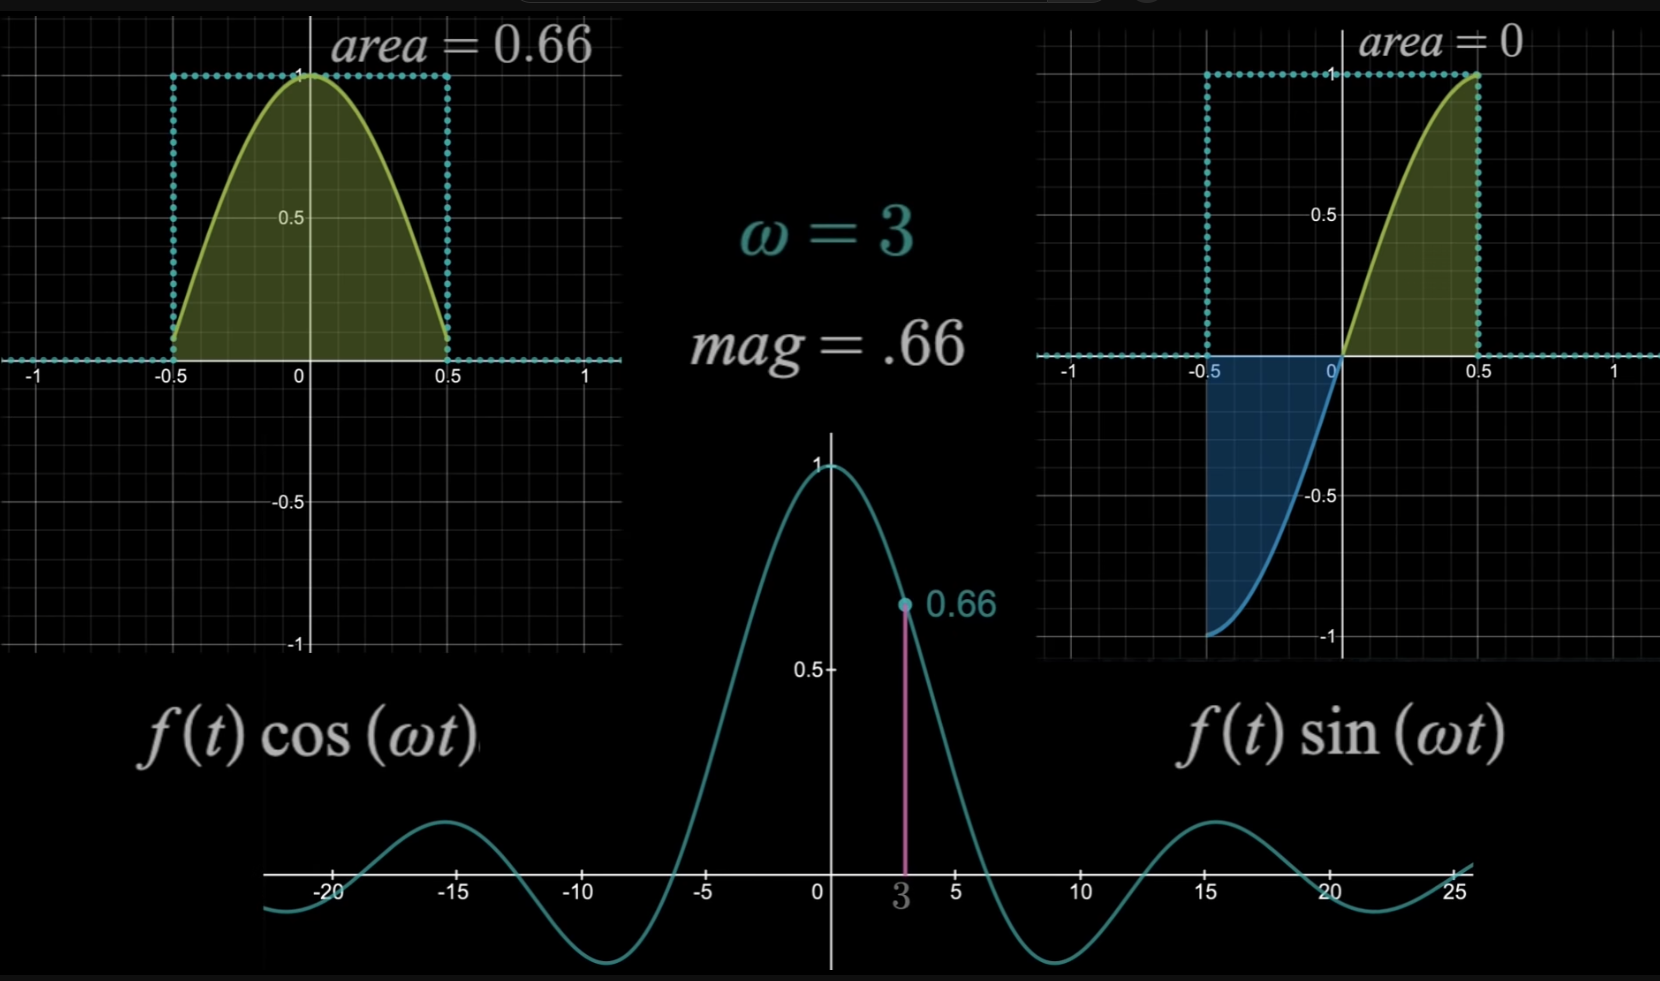

The Fourier analysis kind of scans your original signal for sinusoidal functions: when it is in the wrong one the output is 0, but once it has the right frequency it gives us a high value. This means that we're looking for the $\omega s$ that output an infinite area because those tell us what sinusoids are in our signal.  

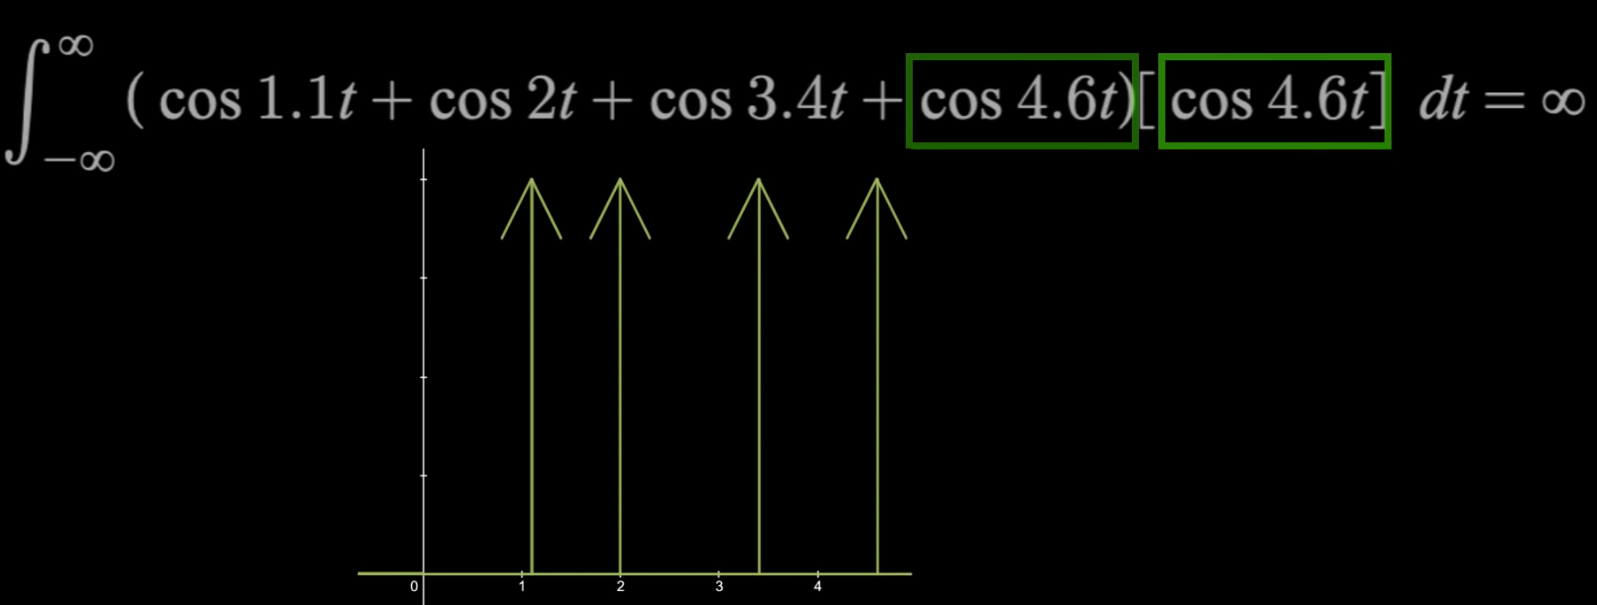



Below you can see a plot with the superposition of two waves, with noise added in. The blue line displays the artificially created wave, while the pink displays the noisy wave. In a real-life scenario, the true wave will be obscured by the noise.

In [2]:
#create sample signal with 2 frequencies
dt = 0.001
t = np.arange(0,1,dt)
f = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t)  #sum of 2 frequencies
f_clean = f
f = f + 2.5*np.random.randn(len(t))               #Add some noise

In [3]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=t,
        y=f,
        line={'color': 'pink', 'width': 1.5},
        name='Noisy'
    )
)
fig.add_trace(
    go.Scatter(
        x=t,
        y=f_clean,
        line={'color': '#194773', 'width': 2},
        name='Clean'
    )
)
fig.update_layout(
    xaxis_title='Radians',
    yaxis_title='Amplitude' 
)
display(Markdown(f"### **Artificial Signal and $Signal + Noise$**"))
fig

### **Artificial Signal and $Signal + Noise$**

## Decomposing the Wave Using Fourier Transform
To increase the computational efficiency of the Fourier Transform (FT) computation, I use the **fast Fourier Transform (FFT)**. It is an algorithm that computes the discrete FT of a sequence or its inverse. Fourier analysis converts a signal from the original domain (often time or space) to a representation in the frequency domain and vice versa.The discrete FT is obtained by decomposing a sequence of values into components of different frequencies. 

Below we can see there are two waves of an approximate amplitude of 280 and 245 units respectively. They have frequencies of about $50Hz$ and $120Hz$.

In [4]:
#compute the FFT algo
n = len(t)
fhat = np.fft.fft(f,n)                     #compute the FFT
PSD = fhat * np.conj(fhat)/n               #power spectrum 
freq = (1/(dt*n)) * np.arange(n)           #x-axis of frequencies 
L = np.arange(1,np.floor(n/2),dtype='int') #only plot 1st half

In [5]:
display(Markdown('### Power Spectral Density of Signal'))
px.line(
    x=freq[L],
    y=np.real(PSD[L]),
    labels={'y': 'Power Spectral Density', 'x':'Frequency (<i>Hz</i>)'}
)

### Power Spectral Density of Signal

Now we filter out waves with amplitude $<100$ on the power spectral density. With the Kronecker Delta Function the waves with an amplitude below 100 are simply computed as zero. Via the **Inverse Fast Fourier Transform** we can then recover the underlying wave that is formed by 2 components via doing the reverse.

In [6]:
#Use PSD to filter out noise
indices = PSD > 100        # Find all freqs with large power
PSDclean = PSD * indices   # zero out all others via kronecker delta
fhat = indices*fhat        # zero out small fourier coffef. in Y
ffilt = np.fft.ifft(fhat)  # inverse fFFT for filtered time signal

In [7]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=t,
        y=f,
        line={'color': 'pink', 'width': 1.5},
        name='Noisy'
    )
)
fig.add_trace(
    go.Scatter(
        x=t,
        y=f_clean,
        line={'color': '#194773', 'width': 2},
        name='Clean'
    )
)
fig.add_trace(
    go.Scatter(
        x=t,
        y=np.real(ffilt),
        line={'color': '#45B39D', 'width': 2},
        name='Filtered'
    )
)
fig.update_layout(
    xaxis_title='Radians',
    yaxis_title='Amplitude' 
)
display(Markdown(
    f"### **Artificial Signal, $Signal + Noise$, Fourier Transform**"
    )
)
fig

### **Artificial Signal, $Signal + Noise$, Fourier Transform**

# Real World Example: Stock Price Prediction

In [16]:
ticker = 'MSFT'
stock_df = yf.download(ticker, period='max')
stock_df.columns = [
    dp.camel_to_snake(col.replace(' ', '')) for col in stock_df.columns
]

# Delimit period to 2011 onwards
stock_test_df = stock_df.loc['2020':]
stock_df = stock_df.loc['2011':'2016']

[*********************100%%**********************]  1 of 1 completed


In [17]:
stock_df.loc['2011']

,open,high,low,close,adj_close,volume
Date,,,,,,
2011-01-03,28.049999,28.180000,27.920000,27.980000,21.664238,53443800
2011-01-04,27.940001,28.170000,27.850000,28.090000,21.749407,54405600
2011-01-05,27.900000,28.010000,27.770000,28.000000,21.679726,58998700
2011-01-06,28.040001,28.850000,27.860001,28.820000,22.314625,88026300
2011-01-07,28.639999,28.740000,28.250000,28.600000,22.144295,73762000
...,...,...,...,...,...,...
2011-12-23,25.910000,26.040001,25.730000,26.030001,20.689846,23205800
2011-12-27,25.959999,26.139999,25.930000,26.040001,20.697792,21287200
2011-12-28,26.110001,26.150000,25.760000,25.820000,20.522921,29822500


In [18]:
display(Markdown(f'### **{ticker} Daily Adjusted Close Price**'))
px.line(
    x=stock_df.index,
    y=stock_df['adj_close'],
    labels={'y': 'Price (USD)', 'x': 'Date'}
)

### **MSFT Daily Adjusted Close Price**

In [19]:
# Extract only adjusted close price for FT
df = stock_df[['adj_close']]

# Compute USD daily variations in price
df['delta'] = df['adj_close'].pct_change().fillna(0)

# Find first computing date
first_date = df.index[1]

# Compute the discrete  Fourier Transform with the fast FT algorithm
dft = np.fft.fft(df.loc[first_date:, 'delta'].values)

# Compute theta, amplitude and frequency
df.loc[first_date:, 'theta'] = np.arctan(dft.imag/dft.real)
df.loc[first_date:, 'amplitude'] = (
    np.sqrt(dft.real ** 2 + dft.imag ** 2) / (len(df) / 2)
)
df.loc[first_date:, 'frequency'] = np.fft.fftfreq(dft.size, d=1)

df.head()

,adj_close,delta,theta,amplitude,frequency
Date,,,,,
2011-01-03,21.664238,0.000000,NaN,NaN,NaN
2011-01-04,21.749407,0.003931,3.696855e-17,0.001492,0.000000
2011-01-05,21.679726,-0.003204,-4.009574e-01,0.000284,0.000663
2011-01-06,22.314625,0.029285,5.864863e-01,0.000239,0.001325
2011-01-07,22.144295,-0.007633,2.162832e-01,0.000559,0.001988


With the *frequency* and *amplitude* values we can determine the dominant frequency. For any FT function, we will have a mirror image along the middle (marked by the crimson vertical line). 

In [20]:
display(Markdown('### **Frequency Domain**'))
fig = px.scatter(
    data_frame=df,
    x='frequency',
    y='amplitude',
    labels={'amplitude': 'Amplitude (USD)', 'frequency': 'Frequency (Days)'}
)
fig.add_vline(x=0, line={'color':'crimson'})


### **Frequency Domain**

We'll take the positive frequency values as well as filter out any frequency with an amplitude over 3 standard deviations:

In [21]:
n_sigma = 2
dominant_amplitude_mask = (
    df['amplitude'] > (n_sigma * df['amplitude'].std() + df['amplitude'].mean())
)
positive_frequency_mask = df['frequency'] > 0
filtered_df = df.loc[dominant_amplitude_mask & positive_frequency_mask]

# Generate plot
display(Markdown('### **Frequency Domain** (Dominant and Positive)'))
fig = px.scatter(
    data_frame=filtered_df,
    x='frequency',
    y='amplitude',
    labels={'amplitude': 'Amplitude (USD)', 'frequency': 'Frequency (Days)'}
)
fig

### **Frequency Domain** (Dominant and Positive)

With the dominant frequency values we can attempt to reconstruct the stock prices. Since we've using the time delta, we will perform a cumulative sum on all the time deltas and add it to the initial adjusting closing stock value to perform a regression. 

In [22]:
reg_delta = 0

for n in range(len(filtered_df)):
    shift = filtered_df.iloc[n]['theta']
    reg_delta += (
        filtered_df.iloc[n]['amplitude'] *
        np.cos(n * np.array(range(len(df) - 1)) + shift)
    )

# df['regression'] = df.loc[df.index.min(), 'adj_close'] + np.cumsum(reg_delta)
df.loc[first_date:, 'regression'] = (
    df.loc[df.index.min(), 'adj_close'] * np.cumprod(1 + reg_delta)
)
df.loc[df.index.min(), 'regression'] = df.loc[df.index.min(), 'adj_close']
rmse = np.sqrt(np.mean((df['adj_close'] - df['regression']) ** 2))

In [23]:
df

,adj_close,delta,theta,amplitude,frequency,regression
Date,,,,,,
2011-01-03,21.664238,0.000000,NaN,NaN,NaN,21.664238
2011-01-04,21.749407,0.003931,3.696855e-17,0.001492,0.000000,22.336127
2011-01-05,21.679726,-0.003204,-4.009574e-01,0.000284,0.000663,22.243324
2011-01-06,22.314625,0.029285,5.864863e-01,0.000239,0.001325,22.209082
2011-01-07,22.144295,-0.007633,2.162832e-01,0.000559,0.001988,22.185669
...,...,...,...,...,...,...
2016-12-23,57.741344,-0.004878,-9.574079e-01,0.000945,-0.003313,66.217016
2016-12-27,57.777859,0.000632,6.285945e-01,0.000367,-0.002651,66.744645
2016-12-28,57.513073,-0.004583,-2.162832e-01,0.000559,-0.001988,67.181277


In [24]:
display(
    Markdown(
        f'### **Fourier Transform**: ${n_sigma}\sigma$ Dominant Amplitudes\n'
        f'$RMSE = USD {rmse:.2f}$'
    )
)
px.line(
    data_frame=df,
    x=df.index,
    y=['adj_close', 'regression'],
    labels={'value': 'USD'},
)

### **Fourier Transform**: $2\sigma$ Dominant Amplitudes
$RMSE = USD 8.69$

In [25]:
df

,adj_close,delta,theta,amplitude,frequency,regression
Date,,,,,,
2011-01-03,21.664238,0.000000,NaN,NaN,NaN,21.664238
2011-01-04,21.749407,0.003931,3.696855e-17,0.001492,0.000000,22.336127
2011-01-05,21.679726,-0.003204,-4.009574e-01,0.000284,0.000663,22.243324
2011-01-06,22.314625,0.029285,5.864863e-01,0.000239,0.001325,22.209082
2011-01-07,22.144295,-0.007633,2.162832e-01,0.000559,0.001988,22.185669
...,...,...,...,...,...,...
2016-12-23,57.741344,-0.004878,-9.574079e-01,0.000945,-0.003313,66.217016
2016-12-27,57.777859,0.000632,6.285945e-01,0.000367,-0.002651,66.744645
2016-12-28,57.513073,-0.004583,-2.162832e-01,0.000559,-0.001988,67.181277


Generate an optimization process to determine the optimum standard deviation value cut-off for dominant amplitudes and $\theta s$ that minimize the RMSE. I used a custom minimization function.

**Notes**
+ `scipy.optimize.minimize_scalar` doesn't work well, as it gets stuck in local minima
+ `scipy.optimize.minimize` doesn't converge

***
Compute an dynamically-adjusted FT:
+ Compute a rolling-window RMSE: if it is over a certain *percentage* of the current price, take a smaller window and re-compute the dominant values for $\theta$, amplitude and frequency. 
+ Mark times where there was a correction. Also you need to workout the range of the smaller window, and until were to re-compute the regression value for the FT with the new dominant values. 
***

In [15]:
def compute_rmse_from_std(std_value):
    # Extract value if not number
    if not(isinstance(std_value, float) or isinstance(std_value, int)):
        std_value = std_value[0]

    # Get dominant values based on input standard deviation
    mean_amp = df['amplitude'].mean()
    std_amp = df['amplitude'].std()

    # Generate masks for dominant and positive frequency values
    dominant_amp_mask = df['amplitude'] > (std_value * std_amp + mean_amp)
    positive_freq_mask = df['frequency'] > 0
    
    # Select only dominant values
    cols = ['amplitude', 'frequency', 'theta']
    filtered_df = df.loc[dominant_amp_mask & positive_freq_mask, cols]

    # Calculate regression delta
    reg_delta = 0
    for n in range(len(filtered_df)):
        shift = filtered_df.iloc[n]['theta']
        reg_delta += (
            filtered_df.iloc[n]['amplitude'] *
            np.cos(n * np.array(range(len(df) - 1)) + shift)
        )
        
    # Convert time delta to time from starting point
    df.loc[first_date:, 'regression'] = (
        df.loc[df.index.min(), 'adj_close'] * np.cumprod(1 + reg_delta)
    )
    df.loc[df.index.min(), 'regression'] = df.loc[df.index.min(), 'adj_close']

    # Compute RMSE
    rmse = np.sqrt(np.mean((df['adj_close'] - df['regression']) ** 2))
    
    return np.array(rmse)

std_0 = 0.001

In [16]:
def optimize(
            funct, 
            bounds: tuple, 
            tests: int, 
            best_guess: float,
            relevant_diff: float = 0.001
            ):
    
    # Define the search space
    input_values = np.linspace(bounds[0], bounds[1], num=tests)

    # Compute loss in search space: find value that minimizes output
    min_output = 1e100000
    for i, n in enumerate(input_values):

        # Compute loss
        output = funct(n)

        # Move towards global minimum
        if output < min_output:
            min_index = i
            min_value = n
            diff = min_output - output
            min_output = output

            # Return output if there is very small or no progress 
            if diff <= relevant_diff:
                return min_value, min_output
            
    # Test for very small change in initial guess and minimum found
    if max((best_guess, min_value)) / min((best_guess, min_value)) - 1 < 0.01:
        return min_value, min_output
    
    # Define bounds for next zoomed-in iteration
    if min_index == 0:
        lower_bound = bounds[0]
    elif min_index == len(input_values) - 1:
        print(f"Minimum value didn't converge, got to {min_value}")
        return min_value, min_output
    else:
        lower_bound = input_values[min_index -1]
    upper_bound = input_values[min_index + 1]
    
    # Recurse in zoomed-in search space
    min_value, min_output = optimize(
        funct=funct,
        tests=tests,
        bounds=(lower_bound, upper_bound),
        best_guess=min_value,
        relevant_diff=relevant_diff
    )
    
    return min_value, min_output



In [17]:
min_value, min_output = optimize(
    funct=compute_rmse_from_std,
    bounds=(0, 4),
    best_guess=0.7,
    tests=500,
    relevant_diff=0.0001
)

In [18]:
# Compute the rolling-window RMSE
window_size = 20
df['squared_diff'] = (df['adj_close'] - df['regression']) ** 2
df['rolling_rmse'] = (
    np.sqrt(df['squared_diff'].rolling(window=window_size).mean())
)

# Compute the overall RMSE
final_rmse = compute_rmse_from_std(min_value)

# Generate title and subtitle
display(
    Markdown(
        f'### **Fourier Transform**: ${min_value:.2f}\sigma$ Dominant Amplitudes\n'
        f'#### Total $RMSE = USD {final_rmse:.2f}$'
    )
)

# Generate plot
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df['adj_close'],
        name='Adj. Close Price'
    )
)
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df['regression'],
        name='Fourier Transform'
    )
)
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df['rolling_rmse'],
        name=f'{window_size}-day RMSE',
        yaxis='y2'
    )
)
fig.update_layout(
    yaxis1=dict(
        title='<b>USD</b><sup><br><i>(Prices)</i></br>'
    ),
    yaxis2=dict(
        title='<b>USD</b><sup><br><i>(RMSE)</i></br>',
        side='right',
        overlaying='y',
        anchor='x'
    )
)

### **Fourier Transform**: $0.63\sigma$ Dominant Amplitudes
#### Total $RMSE = USD 4.35$